In [111]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [112]:
# !ls "/content/gdrive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing"

In [113]:
#!unzip -q "/content/gdrive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/anime_faces.zip" -d "/content/gdrive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/anime_faces"

## 1.1 Imports

In [114]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf


if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1.2. Classes and look at the dataset

In [115]:
class ColorizationDataset(Dataset):
    def __init__(self, image_size, cuda=False):
        self.image_size = image_size
        self.cuda = cuda
    def __len__(self):
        return len(os.listdir('/content/gdrive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/anime_faces/data/'))

    def __getitem__(self, idx):
        with Image.open(f'/content/gdrive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/anime_faces/data/{str(idx+1)}.png') as image:
            img = image.copy()
            
        compose_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        Y = compose_transforms(img)
        X = (Y[0] * 0.299 + Y[1] * 0.587 + Y[2] * 0.114).reshape(1, 64, 64)
        if self.cuda:
            X = X.to(device)
            Y = Y.to(device)
        return X, Y

In [116]:
dset = ColorizationDataset(64)
batch_size = 32
dataset, _ = torch.utils.data.random_split(dset, [int(len(dset)/4), len(dset)-int(len(dset)/4)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [117]:
def to_numpy_image(img):
    img = img.cpu()
    return img.detach().transpose(0, 1).transpose(1, 2).numpy()

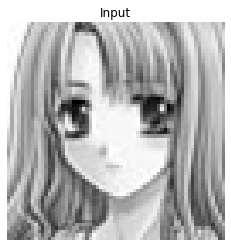

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


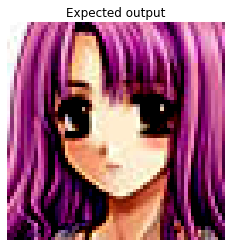

In [118]:
x,y = dset[1]

plt.imshow(x.reshape(64, 64,1)[:,:,0], cmap='gray')
plt.title("Input")
plt.axis('off')
plt.show()

plt.title("Expected output")
plt.axis('off')
plt.imshow(to_numpy_image(y))
plt.show()

---

# 2. Typical CNN

## 2.1. Training the model

In [119]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(64,64,1)))

model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=None,padding='same'))

model.add(tf.keras.layers.Convolution2D(32, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Convolution2D(32, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=None,padding='same'))

model.add(tf.keras.layers.Convolution2D(16, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Convolution2D(16, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides=None,padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(12288, activation='relu')) #64*64*3=12288

model.summary()

model.compile(loss='MSE',optimizer='adam',metrics=["accuracy"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                 

In [120]:
X_train = [dset[i][0].numpy().reshape(64,64,1) for i in range(int(len(dset)/2))]
Y_train = [dset[i][1].numpy().reshape(12288) for i in range(int(len(dset)/2))]
X_valid = [dset[i][0].numpy().reshape(64,64,1) for i in range(int(len(dset)/2)+1,len(dset)-4)]
Y_valid = [dset[i][1].numpy().reshape(12288) for i in range(int(len(dset)/2)+1,len(dset)-4)]

In [121]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

history = model.fit(X_train,Y_train,batch_size=64,epochs=32, validation_data=(X_valid,Y_valid))

Epoch 1/32
169/169 [==============================] - 10s 54ms/step - loss: 0.2397 - accuracy: 9.2799e-05 - val_loss: 0.2005 - val_accuracy: 0.0029
Epoch 2/32
169/169 [==============================] - 8s 46ms/step - loss: 0.2013 - accuracy: 4.6399e-04 - val_loss: 0.1897 - val_accuracy: 0.0010
Epoch 3/32
169/169 [==============================] - 8s 46ms/step - loss: 0.1938 - accuracy: 7.4239e-04 - val_loss: 0.1855 - val_accuracy: 0.0000e+00
Epoch 4/32
169/169 [==============================] - 8s 47ms/step - loss: 0.1900 - accuracy: 5.5679e-04 - val_loss: 0.1834 - val_accuracy: 1.8568e-04
Epoch 5/32
169/169 [==============================] - 8s 47ms/step - loss: 0.1875 - accuracy: 0.0013 - val_loss: 0.1817 - val_accuracy: 0.0000e+00
Epoch 6/32
169/169 [==============================] - 8s 47ms/step - loss: 0.1856 - accuracy: 4.6399e-04 - val_loss: 0.1805 - val_accuracy: 9.2842e-05
Epoch 7/32
169/169 [==============================] - 8s 47ms/step - loss: 0.1842 - accuracy: 5.5679e-04 

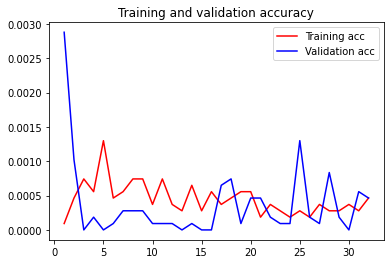

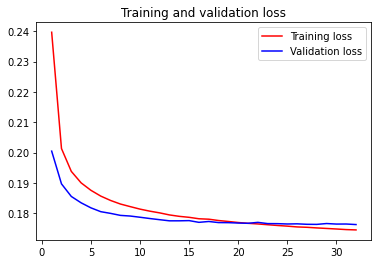

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2.2. Simple CNN results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


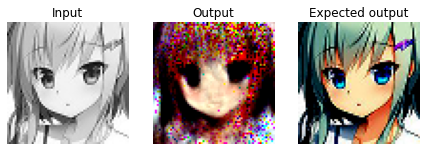

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


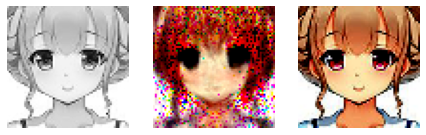

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


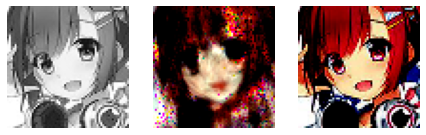

In [124]:
for i in range(1,4):
    x,y = dset.__getitem__(len(dset)-i-1)
    x = x.numpy().reshape(-1,64,64,1)
    plt.figure(figsize=(10,10))
    plt.subplot(141)
    plt.axis('off')
    if i==1:
        plt.title('Input')
    plt.imshow(x.reshape(64, 64,1)[:, :, 0], cmap='gray')
    y_pred = torch.from_numpy(model.predict(x))
    aff=(y_pred.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy()
    plt.subplot(142)
    plt.imshow(aff)
    if i==1:
        plt.title('Output')
    plt.axis('off')
    plt.subplot(143)
    if i==1:
        plt.title('Expected output')
    plt.axis('off')
    plt.imshow((y.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy())
    plt.show()

---

# 3. U-NET Architecture with TensorFlow

## 3.1. Training the model

In [125]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(64,64,1)))

#contracting path
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

#expansive path
model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2,2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Convolution2D(128, (3, 3), padding='same'))
model.add(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2,2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(64, (3, 3)))
model.add(tf.keras.layers.Convolution2D(64, (3, 3)))
model.add(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2,2), padding='valid'))

model.add(tf.keras.layers.Convolution2D(3, (1, 1), padding='same'))


model.summary()

model.compile(loss='MSE',optimizer='adam',metrics=["accuracy"])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_75 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_77 (Conv2D)          (None, 26, 26, 128)       147584    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                 

In [126]:
X_train = [dset[i][0].numpy().reshape(64,64,1) for i in range(int(3*len(dset)/4))]
Y_train = [dset[i][1].numpy().reshape(64,64,3) for i in range(int(3*len(dset)/4))]
X_valid = [dset[i][0].numpy().reshape(64,64,1) for i in range(int(3*len(dset)/4)+1,len(dset)-4)]
Y_valid = [dset[i][1].numpy().reshape(64,64,3) for i in range(int(3*len(dset)/4)+1,len(dset)-4)]

In [127]:
X_train = np.array(X_train)
Y_train= np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

history = model.fit(X_train,Y_train,batch_size=64,epochs=32, validation_data=(X_valid,Y_valid))

Epoch 1/32
253/253 [==============================] - 24s 91ms/step - loss: 0.3061 - accuracy: 0.3461 - val_loss: 0.2342 - val_accuracy: 0.3695
Epoch 2/32
253/253 [==============================] - 21s 85ms/step - loss: 0.2256 - accuracy: 0.3768 - val_loss: 0.2011 - val_accuracy: 0.3796
Epoch 3/32
253/253 [==============================] - 21s 85ms/step - loss: 0.2041 - accuracy: 0.3858 - val_loss: 0.1855 - val_accuracy: 0.3844
Epoch 4/32
253/253 [==============================] - 21s 85ms/step - loss: 0.1930 - accuracy: 0.3911 - val_loss: 0.1810 - val_accuracy: 0.3887
Epoch 5/32
253/253 [==============================] - 21s 84ms/step - loss: 0.1852 - accuracy: 0.3941 - val_loss: 0.1740 - val_accuracy: 0.3909
Epoch 6/32
253/253 [==============================] - 21s 84ms/step - loss: 0.1800 - accuracy: 0.3960 - val_loss: 0.1723 - val_accuracy: 0.3910
Epoch 7/32
253/253 [==============================] - 21s 84ms/step - loss: 0.1758 - accuracy: 0.3972 - val_loss: 0.1679 - val_accuracy:

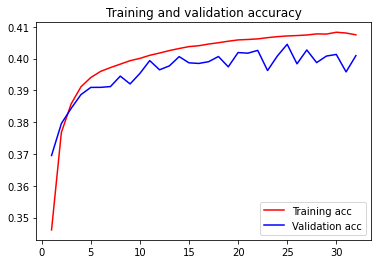

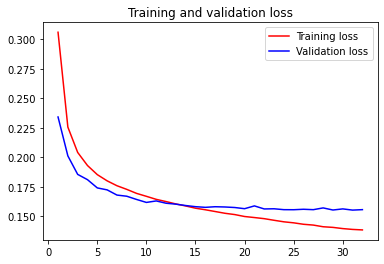

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 3.2. Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


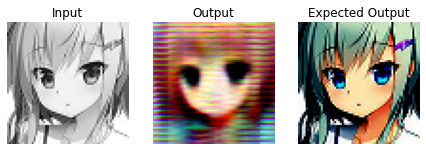

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


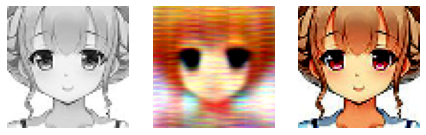

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


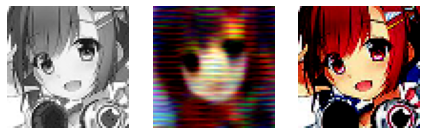

In [130]:
for i in range(1,4):
    x,y = dset.__getitem__(len(dset)-i-1)
    x = x.numpy().reshape(-1,64,64,1)
    plt.figure(figsize=(10,10))
    plt.subplot(141)
    plt.axis('off')
    if i==1:
        plt.title('Input')
    plt.imshow(x.reshape(64, 64,1)[:, :, 0], cmap='gray')
    y_pred = torch.from_numpy(model.predict(x))
    aff=(y_pred.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy()
    plt.subplot(142)
    plt.imshow(aff)
    if i==1:
        plt.title('Output')
    plt.axis('off')
    plt.subplot(143)
    if i==1:
        plt.title('Expected Output')
    plt.axis('off')
    plt.imshow((y.reshape(3, 64, 64)).transpose(0, 1).transpose(1, 2).numpy())
    plt.show()

---

# 4. Different U-NET Architecture Pytorch

## 4.1. Training the model

In [131]:
dset = ColorizationDataset(64, cuda=True) #USE THE GPU
dataset, _ = torch.utils.data.random_split(dset, [int(len(dset)/4), len(dset)-int(len(dset)/4)])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [132]:
class Colorizer(nn.Module):

    def __init__(self):
        super(Colorizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 256, 3, 2, 1)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 2, dilation=2)
        self.conv5 = nn.Conv2d(256, 256, 3, 1, 2, dilation=2)
        self.conv6 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.conv7 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv8 = nn.ConvTranspose2d(64, 3, 3, 2, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(64)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        y = self.bn1(self.leakyrelu(self.conv1(x)))
        y = self.bn2(self.leakyrelu(self.conv2(y)))
        y = self.bn3(self.leakyrelu(self.conv3(y)))
        y = self.bn4(self.leakyrelu(self.conv4(y)))
        y = self.bn5(self.leakyrelu(self.conv5(y)))
        y = self.bn6(self.leakyrelu(self.conv6(y)))
        y = self.bn7(self.leakyrelu(self.conv7(y)))
        y = self.tanh(self.conv8(y))
        return y

In [133]:
model = Colorizer()

if torch.cuda.is_available(): 
    model.to(device)

In [137]:
num_epochs = 8 #RAM eater
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

history = []
for epoch in range(num_epochs):
    for x, y in tqdm(dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        history.append(loss.item())
        loss.backward()
        optimizer.step()

100%|██████████| 169/169 [00:13<00:00, 12.11it/s]


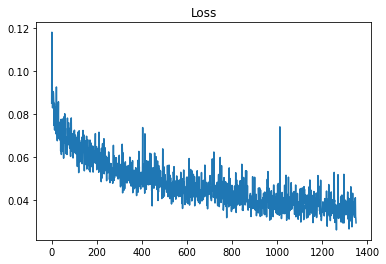

In [138]:
plt.plot(history)
plt.title('Loss')
plt.show()

## 4.2. Pytorch model results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


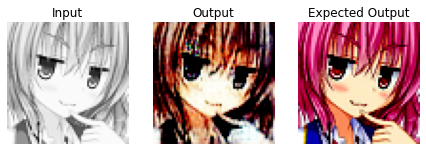

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


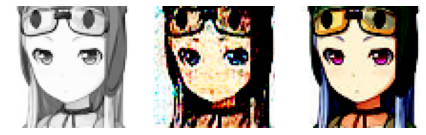

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


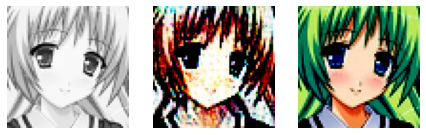

In [139]:
for i in range(3):
    rng = np.random.randint(len(dset))
    img_gray, img_true = dset[rng]
    img_pred = model(img_gray.reshape(1, 1, 64, 64))
    img_pred = to_numpy_image(img_pred.reshape(3, 64, 64))
    plt.figure(figsize=(10,10))
    plt.subplot(141)
    if i==0:
        plt.title('Input')
    plt.axis('off')
    plt.imshow(1-to_numpy_image(img_gray).reshape((64, 64)), cmap= 'Greys')
    plt.subplot(142)
    if i==0:
        plt.title('Output')
    plt.axis('off')
    plt.imshow(img_pred)
    plt.subplot(143)
    if i==0:
        plt.title('Expected Output')
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    plt.show()